In [17]:
import os
from astropy.io import fits
from astropy.wcs import WCS
from spectral_cube import SpectralCube
import regions
import radio_beam
from astropy.coordinates import SkyCoord
from astropy import units as u
import pylab as pl

In [18]:
coord = SkyCoord("17:45:57.7530532310 -28:57:10.7694483833", unit=(u.h, u.deg), frame='icrs')
coord.galactic

<SkyCoord (Galactic): (l, b) in deg
    (0.0246741, -0.0727428)>

In [87]:
region = regions.RectangleSkyRegion(center=coord, width=15*u.arcsec, height=15*u.arcsec)
smallregion = regions.RectangleSkyRegion(center=coord, width=4*u.arcsec, height=4*u.arcsec)
mediumregion = regions.RectangleSkyRegion(center=coord, width=10*u.arcsec, height=10*u.arcsec)
cutregion = regions.CircleSkyRegion(center=coord, radius=15*u.arcsec) # circumscribe the above region so we can match RA/Dec to Galactic

In [20]:
bigregion = regions.RectangleSkyRegion(center=coord, width=35*u.arcsec, height=35*u.arcsec)
bigcircregion = regions.CircleSkyRegion(center=coord, radius=35*u.arcsec)

In [21]:
biggerregion = regions.RectangleSkyRegion(center=coord, width=65*u.arcsec, height=65*u.arcsec)

In [43]:
def galactic_cutout(hdu, reg, precut=biggerregion):
    import reproject.mosaicking, reproject

    try:
        hdu = hdu[0]
    except Exception as ex:
        pass

    csys = WCS(hdu.header)
    preg = precut.to_pixel(csys)
    msk = preg.to_mask()
    slcs,_ = msk.get_overlap_slices(hdu.data.shape)
    hdu = fits.PrimaryHDU(data=hdu.data[slcs], header=csys[slcs].to_header())
    
    csys, sz = reproject.mosaicking.find_optimal_celestial_wcs(hdu, frame='galactic')
    newdata, _ = reproject.reproject_interp(input_data=hdu,
                                            output_projection=csys,
                                            shape_out=sz)
    preg = reg.to_pixel(csys)
    msk = preg.to_mask()
    slcs,_ = msk.get_overlap_slices(newdata.shape)
    new_hdu = fits.PrimaryHDU(data=newdata[slcs], header=csys[slcs].to_header())
    return new_hdu, csys[slcs]

### NIR cont

In [31]:
from astropy.visualization import simple_norm

In [32]:
fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
if not os.path.exists(fn):
    fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.oldhigh_spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
contcube = SpectralCube.read(fn)
fh = fits.open(fn)
contwcs = WCS(fh[0].header).celestial
preg = region.to_pixel(contwcs)
msk = preg.to_mask()
contim = msk.cutout(fh[0].data.squeeze());
beam = radio_beam.Beam.from_fits_header(fh[0].header)
jtok = beam.jtok(102*u.GHz).value
contim = contim * jtok
contim, contwcs = galactic_cutout((fh[0].data.squeeze(), WCS(fh[0].header).celestial), region)

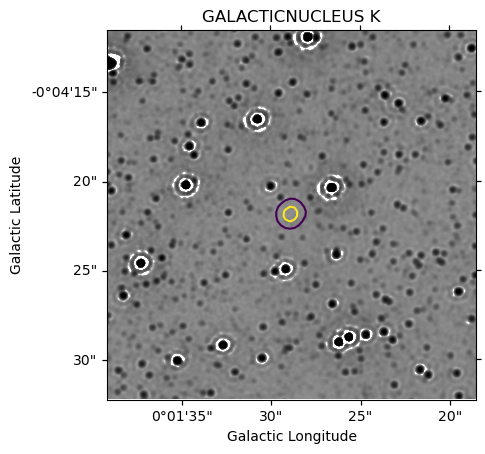

In [33]:
# Show continuum on NIR
fh = fits.open('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/Field6_chip3holo_2_cal.fits')
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='log', max_percent=99.5, min_percent=1),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim.data, transform=ax.get_transform(contwcs),
           levels=[0.0008,  0.0015, ]);
#ax.set_xlabel("Right Ascension")
#ax.grid()
#ax.set_ylabel("Declination")
ax.set_ylabel("")
ax.set_xlabel("")
ax.coords['ra'].set_ticks_visible(False)
ax.coords['dec'].set_ticks_visible(False)
ax.coords['ra'].set_ticklabel_visible(False)
ax.coords['dec'].set_ticklabel_visible(False)
ax.set_title("GALACTICNUCLEUS K")

overlay = ax.get_coords_overlay('galactic')
#overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude')
overlay[1].set_axislabel('Galactic Latitude')
overlay[0].set_axislabel_position('b')
overlay[1].set_axislabel_position('l')
overlay[0].set_ticklabel_position('b')
overlay[1].set_ticklabel_position('l')

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/nir_continuum.pdf', bbox_inches='tight')

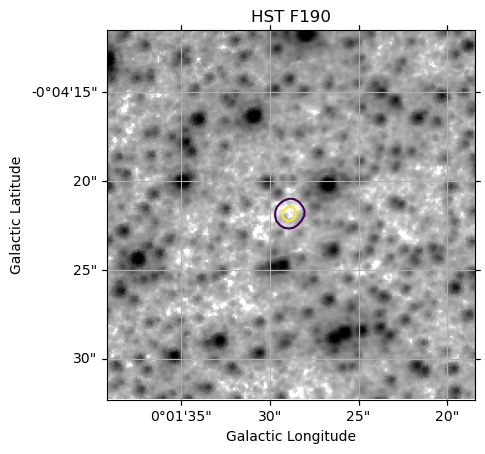

In [35]:
# Show continuum on NIR HST
fh = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_f190n_v1_img.fits')
fh[0].header['CTYPE1'] = 'GLON-TAN'
fh[0].header['CTYPE2'] = 'GLAT-TAN'
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='log', max_percent=99.5, min_percent=1),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim.data, transform=ax.get_transform(contwcs),
           levels=[0.0008,  0.0015, ]);
ax.set_xlabel("Galactic Longitude")
ax.grid()
ax.set_ylabel("Galactic Latitude")
ax.set_title("HST F190")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTF190nir_continuum.pdf', bbox_inches='tight')

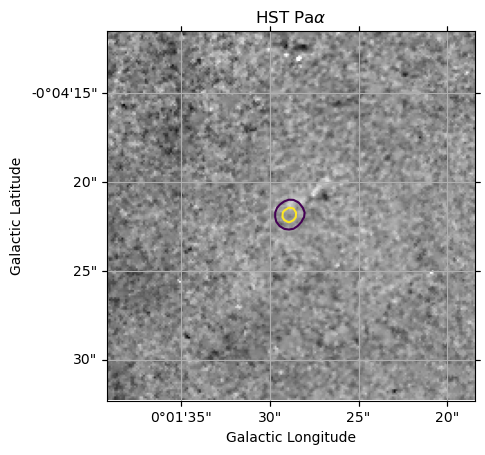

In [36]:
# Show continuum on NIR HST
fh = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_palpha_v1_img.fits')
fh[0].header['CTYPE1'] = 'GLON-TAN'
fh[0].header['CTYPE2'] = 'GLAT-TAN'
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='linear', min_cut=-0.5, max_cut=5),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim.data, transform=ax.get_transform(contwcs),
           levels=[0.0008,  0.0015, ]);
ax.set_xlabel("Galactic Longitude")
ax.grid()
ax.set_ylabel("Galactic Latitude")
ax.set_title("HST Pa$\\alpha$")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTPaAnir.pdf', bbox_inches='tight')

# vizier

In [117]:
from astroquery.vizier import Vizier
print(Vizier.ROW_LIMIT)
Vizier.ROW_LIMIT = 100000
virac = Vizier.query_region(coord, radius=15*u.arcsec, catalog='II/364/virac')[0]
hsc = Vizier.query_region(coord, radius=15*u.arcsec, catalog='II/342/hsc2')[0]
gns = Vizier.query_region(coord, radius=15*u.arcsec, catalog='J/A+A/631/A20/central')[0]
hst_dong = Vizier.query_region(coord, radius=15*u.arcsec, catalog='J/MNRAS/417/114/table2')[0]
pmq = Vizier.query_region(coord, radius=15*u.arcsec, catalog='J/A+A/662/A11/tablea1')[0]
len(virac), len(hsc), len(gns), len(hst_dong), len(pmq)

100000


(63, 1301, 832, 373, 55)

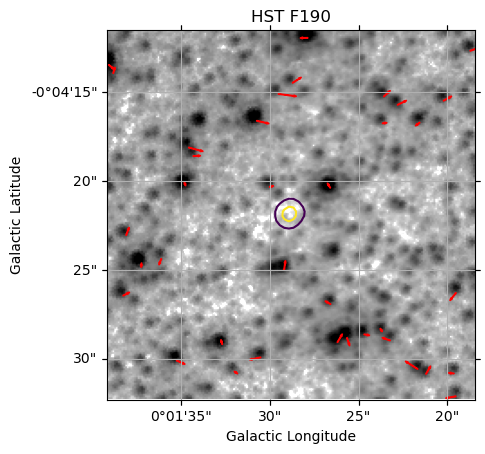

In [118]:
# Show continuum on NIR HST
fh = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_f190n_v1_img.fits')
fh[0].header['CTYPE1'] = 'GLON-TAN'
fh[0].header['CTYPE2'] = 'GLAT-TAN'
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='log', max_percent=99.5, min_percent=1),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim.data, transform=ax.get_transform(contwcs),
           levels=[0.0008,  0.0015, ]);
ax.set_xlabel("Galactic Longitude")
ax.grid()
ax.set_ylabel("Galactic Latitude")
ax.set_title("HST F190")
axlims = ax.axis()

crdpm = SkyCoord(pmq['RAJ2000'], pmq['DEJ2000'], frame='fk5', unit=(u.deg, u.deg)).galactic
#ax.scatter_coord(crdpm, marker='.', s=15)
for row in pmq:
    crdpm = SkyCoord(row['RAJ2000'], row['DEJ2000'], frame='fk5', unit=(u.deg, u.deg)).galactic
    ax.arrow(crdpm.l.deg, crdpm.b.deg, row['pml']/36000, row['pmb']/36000,
             width=1e-5,
             color='r',
             transform=ax.get_transform('world'))

ax.axis(axlims)

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTF190nir_continuum_withPM.pdf', bbox_inches='tight')

In [85]:
ls /orange/adamginsburg/cmz/hst_paschenalpha

hlsp_hpsgc_hst_nicmos-nic3_gc_f187n_v1_img.fits
hlsp_hpsgc_hst_nicmos-nic3_gc_f190n_v1_img.fits
hlsp_hpsgc_hst_nicmos-nic3_gc_palpha_v1_img.fits
hlsp_hpsgc_hst_nicmos-nic3_gc_v1_sou_catalog.fits


# multipanel

In [168]:
fhgns = fits.open('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/Field6_chip3holo_2_cal.fits')
fhpaa = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_palpha_v1_img.fits')
fh190 = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_f190n_v1_img.fits')
fh187 = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_f187n_v1_img.fits')
fh153b = fits.open('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/hst_12663_d1_wfc3_ir_f153m_drz.fits')
fh153 = fits.open('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/hst_12182_d9_wfc3_ir_f153m_drz.fits')
fh127 = fits.open('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/hst_12182_48_wfc3_ir_f127m_drz.fits')
fh139 = fits.open('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/hst_12182_48_wfc3_ir_f139m_drz.fits')
for fh in ([fhpaa, fh190, fh187]):
    fh[0].header['CTYPE1'] = 'GLON-TAN'
    fh[0].header['CTYPE2'] = 'GLAT-TAN'
    
fix_coords = {
 #'HST 1.9': 
 #'HST 1.87': 
 'HST 1.53': (473.9, 1710.0), # 12182
 #'HST 1.53': (447.0, 1693.5), # 12663
 'HST 1.39': (473.9, 1212.1), # 12182 obsid
 'HST 1.27': (473.7, 1212.1),
}

hst_fhs = {
'GNS K': fhgns,
'HST 1.9': fh190,
'HST 1.53': fh153,
'HST 1.39': fh139,
'HST 1.27': fh127,
'HST 1.87': fh187,
}

refstar = SkyCoord(266.49051*u.deg, -28.952704*u.deg, frame='fk5')

for fx in fix_coords:
    fh = hst_fhs[fx]
    fh[1].header['CRPIX1'] = fix_coords[fx][0]
    fh[1].header['CRPIX2'] = fix_coords[fx][1]
    fh[1].header['CRVAL1'] = refstar.ra.deg
    fh[1].header['CRVAL2'] = refstar.dec.deg

In [169]:
stretch_kwargs = {'HST Pa$\\alpha$': dict(stretch='linear', min_cut=-0.5, max_cut=5),
 'GNS K': dict(stretch='log', max_percent=99.0, min_percent=2),
 'HST 1.9': dict(stretch='log', max_percent=99.0, min_percent=0.1),
 'HST 1.87': dict(stretch='log', max_percent=99.0, min_percent=0.1),
 'HST 1.53': dict(stretch='log', max_percent=99.0, min_percent=0.1),
 'HST 1.39': dict(stretch='log', max_percent=99.0, min_percent=0.1),
 'HST 1.27': dict(stretch='log', max_percent=99.0, min_percent=0.1),
 '3.6um': dict(stretch='log', max_percent=99.9, min_percent=3),
 '4.5um': dict(stretch='log', max_percent=99.9, min_percent=3),
 '5.8um': dict(stretch='log', max_percent=99.9, min_percent=3),
 '8.0um': dict(stretch='log', max_percent=99.9, min_percent=0.1),
}

## HST F190, F187, GNS zoomout

0
1
2


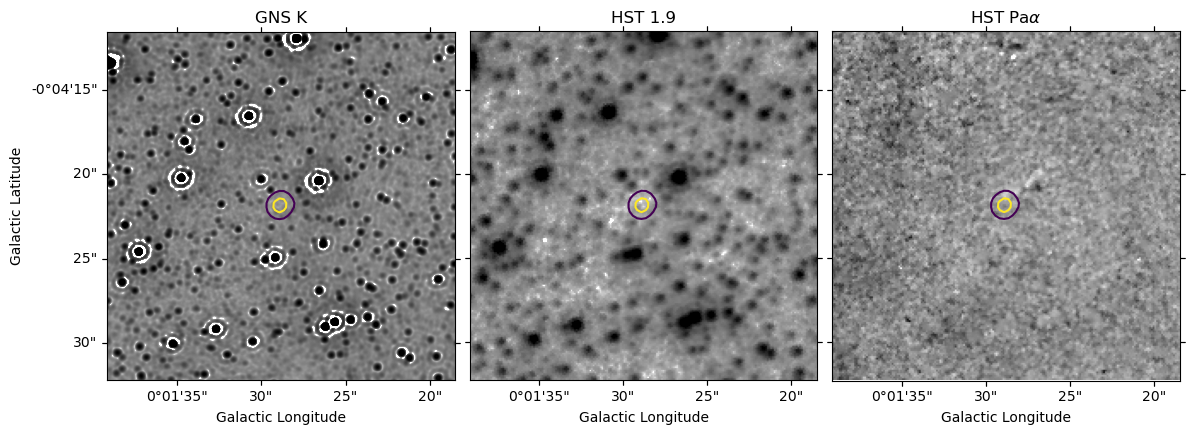

In [170]:
fig = pl.figure(figsize=(12,8))
for ii, (title, fh, ) in enumerate([('GNS K', fhgns), ('HST 1.9', fh190), ('HST Pa$\\alpha$', fhpaa)]):# ('HST 1.53', fh153[1]), ('HST 1.27', fh127[1])]):

    print(ii)
    nirim, nirwcs = galactic_cutout(fh, region)
    
    ax = pl.subplot(1,3,ii+1,projection=nirwcs)
    norm = simple_norm(nirim.data, **stretch_kwargs[title])
    im = ax.imshow(nirim.data, cmap='gray_r', norm=norm)
    lims = ax.axis()
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               levels=[0.0008,  0.0015, ]);

    ax.set_xlabel("Galactic Longitude")
    ax.set_ylabel("Galactic Latitude")
    ax.set_title(title)
    ax.axis(lims)
    if ii > 0:
        ax.set_ylabel("")
        ax.coords['glat'].set_ticklabel_visible(False)
pl.tight_layout()

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HST_GNS_zoomout.pdf', bbox_inches='tight')

0
1
2


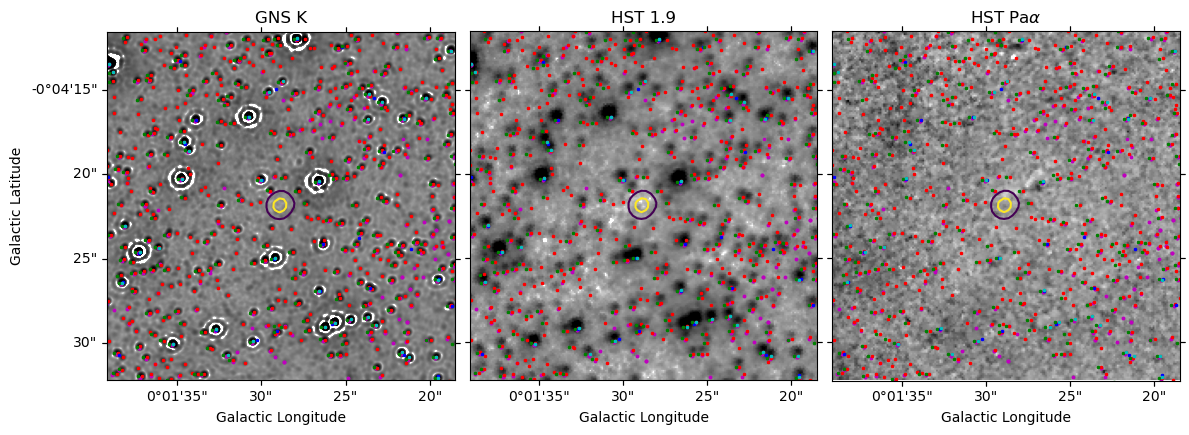

In [171]:
fig = pl.figure(figsize=(12,8))
for ii, (title, fh, ) in enumerate([('GNS K', fhgns), ('HST 1.9', fh190), ('HST Pa$\\alpha$', fhpaa)]):# ('HST 1.53', fh153[1]), ('HST 1.27', fh127[1])]):

    print(ii)
    nirim, nirwcs = galactic_cutout(fh, region)
    
    ax = pl.subplot(1,3,ii+1,projection=nirwcs)
    norm = simple_norm(nirim.data, **stretch_kwargs[title])
    im = ax.imshow(nirim.data, cmap='gray_r', norm=norm)
    lims = ax.axis()
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               levels=[0.0008,  0.0015, ]);
    
    crds = SkyCoord(hsc['RAJ2000'], hsc['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='m', s=3)
    crds = SkyCoord(gns['RAJ2000'], gns['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='r', s=3)
    crds = SkyCoord(virac['RA_ICRS'], virac['DE_ICRS'], frame='icrs', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='b', s=3)
    crds = SkyCoord(hst_dong['RAJ2000'], hst_dong['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='g', s=3)
    crds = SkyCoord(pmq['RAJ2000'], pmq['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='c', s=3)

    ax.set_xlabel("Galactic Longitude")
    ax.set_ylabel("Galactic Latitude")
    ax.set_title(title)
    ax.axis(lims)
    if ii > 0:
        ax.set_ylabel("")
        ax.coords['glat'].set_ticklabel_visible(False)
pl.tight_layout()

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HST_GNS_zoomout_withcats.pdf', bbox_inches='tight')

## HST F190, F187, GNS zoomin

0
1
2


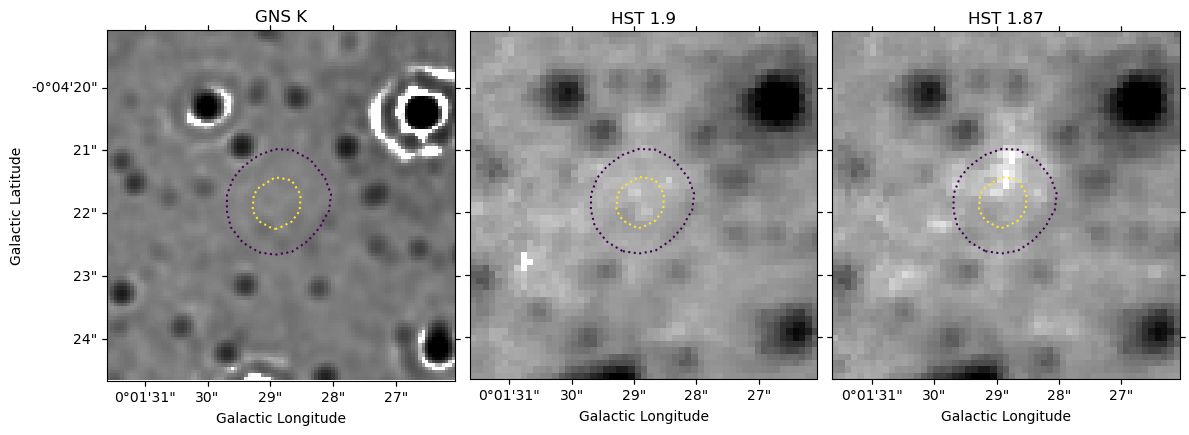

In [172]:
fig = pl.figure(figsize=(12,8))
for ii, (title, fh) in enumerate([('GNS K', fhgns), ('HST 1.9', fh190), ('HST 1.87', fh187)]):# ('HST 1.53', fh153[1]), ('HST 1.27', fh127[1])]):

    print(ii)
    nirim, nirwcs = galactic_cutout(fh, smallregion)
    
    ax = pl.subplot(1,3,ii+1,projection=nirwcs)
    norm = simple_norm(nirim.data, **stretch_kwargs[title])
    im = ax.imshow(nirim.data, cmap='gray_r', norm=norm)
    lims = ax.axis()
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               linestyles=':',
               levels=[0.0008,  0.0015, ]);

    ax.set_xlabel("Galactic Longitude")
    ax.set_ylabel("Galactic Latitude")
    ax.set_title(title)
    ax.axis(lims)
    if ii > 0:
        ax.set_ylabel("")
        ax.coords['glat'].set_ticklabel_visible(False)
pl.tight_layout()

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HST_GNS_zoomin.pdf', bbox_inches='tight')

0
1
2


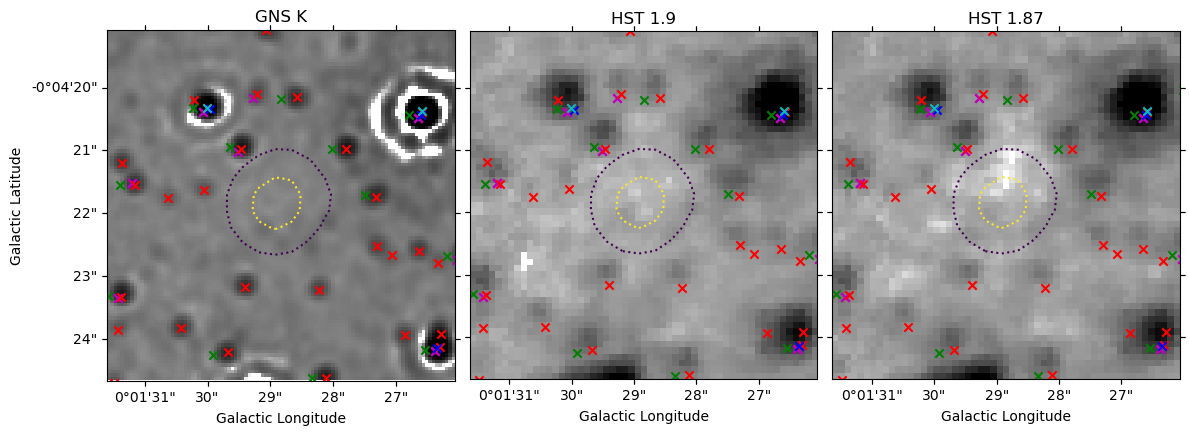

In [173]:
fig = pl.figure(figsize=(12,8))
for ii, (title, fh) in enumerate([('GNS K', fhgns), ('HST 1.9', fh190), ('HST 1.87', fh187)]):# ('HST 1.53', fh153[1]), ('HST 1.27', fh127[1])]):

    print(ii)
    nirim, nirwcs = galactic_cutout(fh, smallregion)
    
    ax = pl.subplot(1,3,ii+1,projection=nirwcs)
    norm = simple_norm(nirim.data, **stretch_kwargs[title])
    im = ax.imshow(nirim.data, cmap='gray_r', norm=norm)
    lims = ax.axis()
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               linestyles=':',
               levels=[0.0008,  0.0015, ]);

    crds = SkyCoord(hsc['RAJ2000'], hsc['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='m')
    crds = SkyCoord(gns['RAJ2000'], gns['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='r')
    crds = SkyCoord(virac['RA_ICRS'], virac['DE_ICRS'], frame='icrs', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='b')
    crds = SkyCoord(hst_dong['RAJ2000'], hst_dong['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='g')
    crds = SkyCoord(pmq['RAJ2000'], pmq['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='c')
    ax.set_xlabel("Galactic Longitude")
    ax.set_ylabel("Galactic Latitude")
    ax.set_title(title)
    ax.axis(lims)
    if ii > 0:
        ax.set_ylabel("")
        ax.coords['glat'].set_ticklabel_visible(False)
pl.tight_layout()

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HST_GNS_zoomin_withcats.pdf', bbox_inches='tight')

## HST all zoomin

In [174]:
print('test')

test


0
1
2
3
4
5


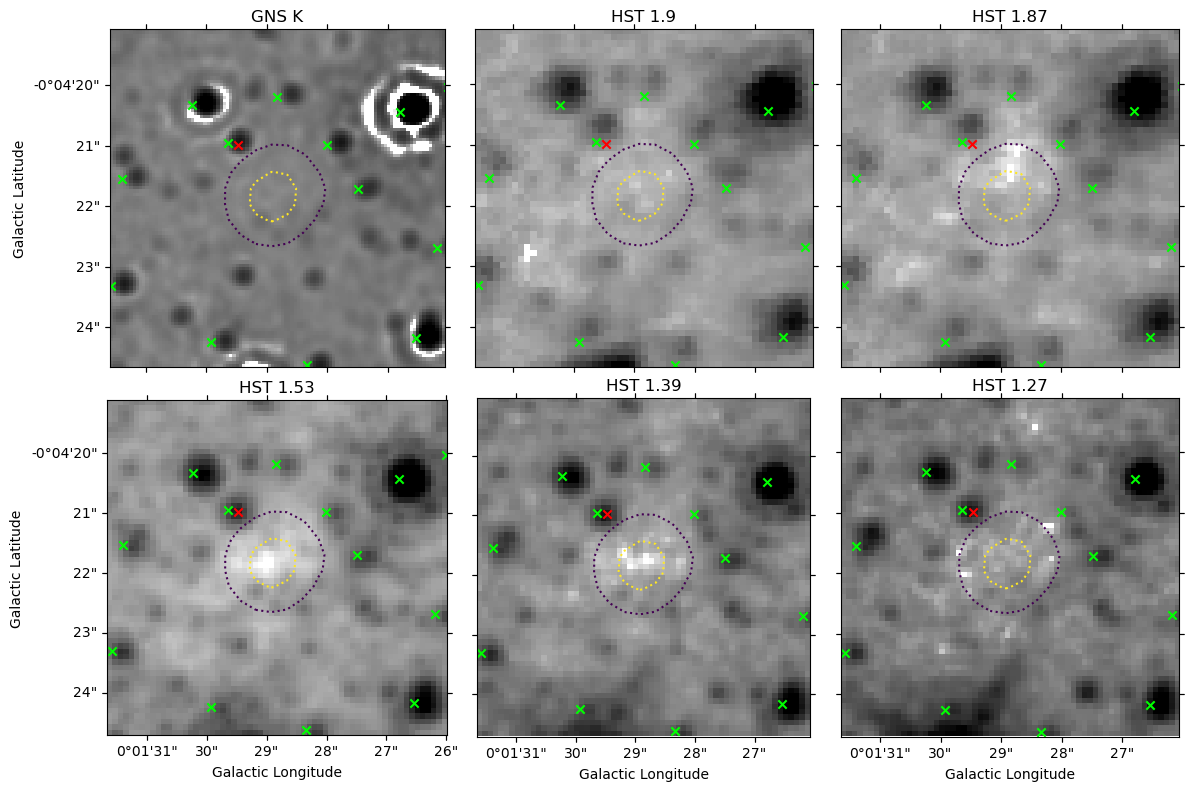

In [175]:
fig = pl.figure(figsize=(12,8))
for ii, (title, fh) in enumerate([('GNS K', fhgns),
                                  ('HST 1.9', fh190),
                                  ('HST 1.87', fh187),
                                  ('HST 1.53', fh153[1]),
                                  ('HST 1.39', fh139[1]),
                                  ('HST 1.27', fh127[1])]):

    print(ii)
    nirim, nirwcs = galactic_cutout(fh, smallregion)
    
    ax = pl.subplot(2,3,ii+1,projection=nirwcs)
    norm = simple_norm(nirim.data, **stretch_kwargs[title])
    im = ax.imshow(nirim.data, cmap='gray_r', norm=norm)
    lims = ax.axis()
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               linestyles=':',
               levels=[0.0008,  0.0015, ]);

    #crds = SkyCoord(hsc['RAJ2000'], hsc['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    #ax.scatter_coord(crds, marker='x', color='m')
    #crds = SkyCoord(gns['RAJ2000'], gns['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    #ax.scatter_coord(crds, marker='x', color='r')
    #crds = SkyCoord(virac['RA_ICRS'], virac['DE_ICRS'], frame='icrs', unit=(u.deg, u.deg))
    #ax.scatter_coord(crds, marker='x', color='b')
    crds = SkyCoord(hst_dong['RAJ2000'], hst_dong['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', color='lime')
    ax.scatter_coord(refstar, marker='x', color='r')
    #crds = SkyCoord(pmq['RAJ2000'], pmq['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    #ax.scatter_coord(crds, marker='x', color='c')
    ax.set_xlabel("Galactic Longitude")
    ax.set_ylabel("Galactic Latitude")
    ax.set_title(title)
    ax.axis(lims)
    if ii % 3 != 0:
        ax.set_ylabel("")
        ax.coords['glat'].set_ticklabel_visible(False)
    if ii < 3:
        ax.set_xlabel("")
        ax.coords['glon'].set_ticklabel_visible(False)
pl.tight_layout()

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTall_GNS_zoomin_withHSTcat.pdf', bbox_inches='tight')

0
1
2
3
4
5


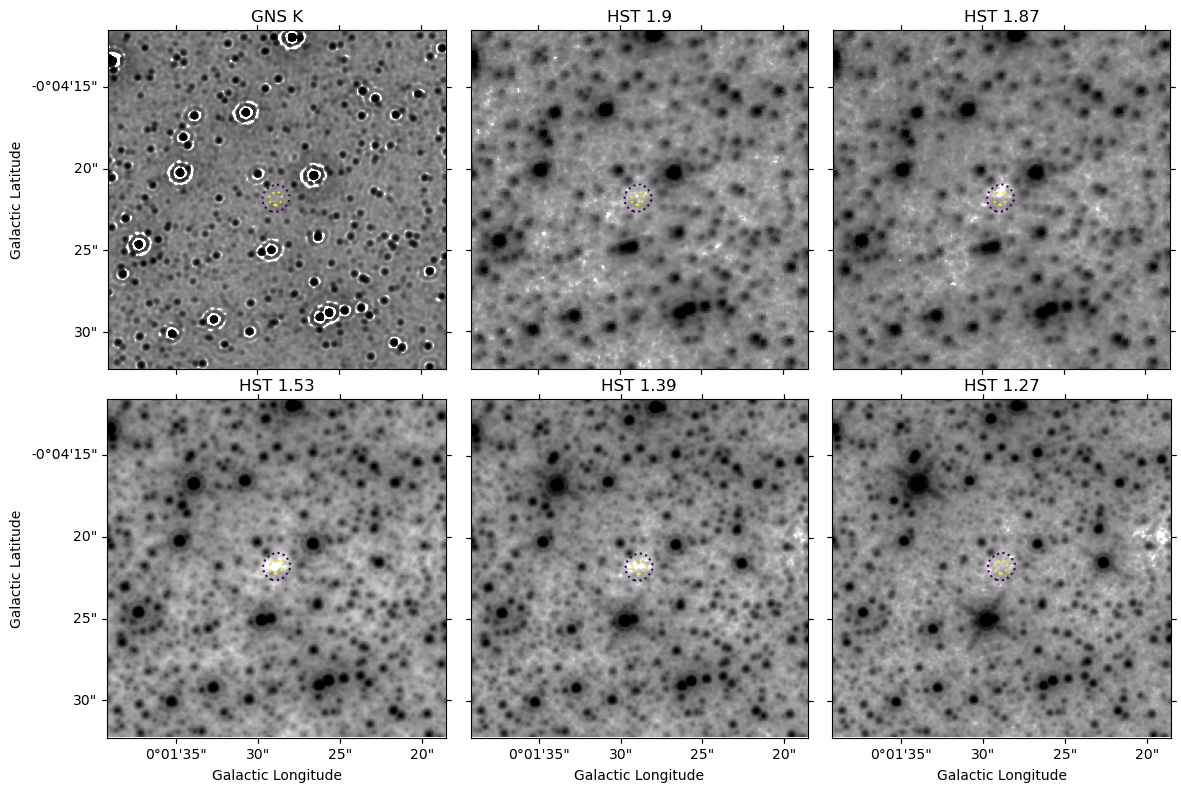

In [176]:
fig = pl.figure(figsize=(12,8))
for ii, (title, fh) in enumerate([('GNS K', fhgns),
                                  ('HST 1.9', fh190),
                                  ('HST 1.87', fh187),
                                  ('HST 1.53', fh153[1]),
                                  ('HST 1.39', fh139[1]),
                                  ('HST 1.27', fh127[1])]):

    print(ii)
    nirim, nirwcs = galactic_cutout(fh, region)
    
    ax = pl.subplot(2,3,ii+1,projection=nirwcs)
    norm = simple_norm(nirim.data, **stretch_kwargs[title])
    im = ax.imshow(nirim.data, cmap='gray_r', norm=norm)
    lims = ax.axis()
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               linestyles=':',
               levels=[0.0008,  0.0015, ]);

    #crds = SkyCoord(hsc['RAJ2000'], hsc['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    #ax.scatter_coord(crds, marker='x', color='m')
    #crds = SkyCoord(gns['RAJ2000'], gns['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    #ax.scatter_coord(crds, marker='x', color='r')
    #crds = SkyCoord(virac['RA_ICRS'], virac['DE_ICRS'], frame='icrs', unit=(u.deg, u.deg))
    #ax.scatter_coord(crds, marker='x', color='b')
    #crds = SkyCoord(hst_dong['RAJ2000'], hst_dong['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    #ax.scatter_coord(crds, marker='x', color='lime')
    #crds = SkyCoord(pmq['RAJ2000'], pmq['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    #ax.scatter_coord(crds, marker='x', color='c')
    ax.set_xlabel("Galactic Longitude")
    ax.set_ylabel("Galactic Latitude")
    ax.set_title(title)
    ax.axis(lims)
    if ii % 3 != 0:
        ax.set_ylabel("")
        ax.coords['glat'].set_ticklabel_visible(False)
    if ii < 3:
        ax.set_xlabel("")
        ax.coords['glon'].set_ticklabel_visible(False)
pl.tight_layout()

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTall_GNS_zoomout.pdf', bbox_inches='tight')

## Hubble Source Catalog analysis

In [127]:
hst_dong[:2]

<Table length=2>
  Pa   Seq   RAJ2000  e_RAJ2000  DEJ2000  e_DEJ2000 SF187N e_SF187N SF190N e_SF190N  F187N   F190N   Nexp  Qual
               deg      arcsec     deg      arcsec   uJy     uJy     uJy     uJy      mag     mag              
uint8 int32  float64   float32   float64   float32  int32   int32   int32   int32   float32 float32 uint8 uint8
----- ----- --------- --------- --------- --------- ------ -------- ------ -------- ------- ------- ----- -----
    0  3457 266.49008      0.02 -28.94929      0.02  25260      447  29380      463    11.3    11.1     4     0
    0  5495 266.48784      0.02 -28.95174      0.02  19472      345  20601      326    11.5    11.5     4     0

In [156]:
hsc[:2]

<Table length=2>
all    RAJ2000     DEJ2000   MatchID      Source    Det      Dist      _tab2_25   _tab2_26  Filter  FluxAper2   magAper2  magAuto  RadKron
         deg         deg                                     mas          d          d                ct / s      mag       mag      pix  
str3   float64     float64     str8       str13     str1   float64     float64    float64    str6    float64    float64   float64  float64
---- ----------- ----------- -------- ------------- ---- ------------ ---------- ---------- ------ ------------ -------- --------- -------
 all 266.4907612 -28.9505499 21106863 6000033869463    Y   90.5133161 55695.8877 55695.9647  F153M       110.25   19.358  19.12940   0.776
 all 266.4907612 -28.9505499 21106863 6000013877121    Y   90.5133161 56193.4129 56193.4455  F153M       139.34   19.103  18.80270   0.669

In [140]:
set(hsc['Filter'])

{'F127M', 'F139M', 'F153M', 'F450W', 'F606W'}

In [163]:
#hsc.group_by('MatchID')
import numpy as np
from astropy import table
hsc.add_index('Filter')
hsc_filts = {filt: hsc.loc[filt] for filt in set(hsc['Filter'])}
for filt, tab in hsc_filts.items():
    del tab['all']
    del tab['Filter']
    for colname in tab.colnames:
        if colname != 'MatchID':
            tab.rename_column(colname, filt+'_'+colname)

hsc_stacked = hsc_filts['F139M']

for filt, right in hsc_filts.items():
    if filt == 'F139M':
        continue
    hsc_stacked = table.join(hsc_stacked, right, keys=['MatchID'], table_names=['origin', filt],
                             join_type='outer')
hsc_stacked[:2]

<Table length=2>
F139M_RAJ2000 F139M_DEJ2000 MatchID   F139M_Source F139M_Det  F139M_Dist  F139M__tab2_25 F139M__tab2_26 F139M_FluxAper2 ... F606W_Det F606W_Dist F606W__tab2_25 F606W__tab2_26 F606W_FluxAper2 F606W_magAper2 F606W_magAuto F606W_RadKron
     deg           deg                                           mas            d              d             ct / s     ...              mas           d              d             ct / s          mag            mag           pix     
   float64       float64      str8       str13        str1     float64       float64        float64         float64     ...    str1    float64      float64        float64         float64        float64        float64       float64   
------------- ------------- -------- ------------- --------- ------------ -------------- -------------- --------------- ... --------- ---------- -------------- -------------- --------------- -------------- ------------- -------------
  266.4860171   -28.9535882 21104462 6000012705787         Y    0.0000000     55604.0387     55604.0524          10.792 ...        --         --             --             --              --             --            --            --
           --            -- 21104473            --        --           --             --             --              -- ...        --         --             --             --              --             --            --            --

In [162]:
hsc_crds = SkyCoord(hsc['RAJ2000'], hsc['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))

0
1
2
3
4
5


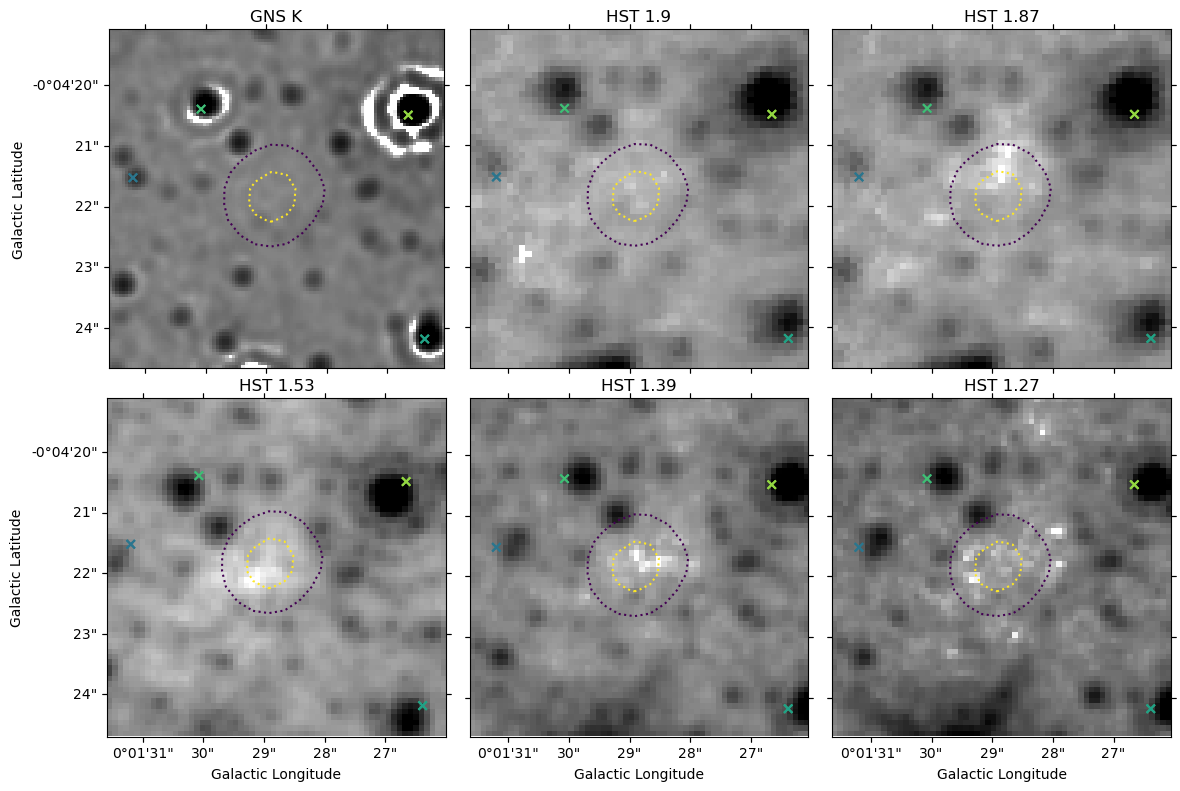

In [164]:
fig = pl.figure(figsize=(12,8))
for ii, (title, fh) in enumerate([('GNS K', fhgns),
                                  ('HST 1.9', fh190),
                                  ('HST 1.87', fh187),
                                  ('HST 1.53', fh153[1]),
                                  ('HST 1.39', fh139[1]),
                                  ('HST 1.27', fh127[1])]):

    print(ii)
    nirim, nirwcs = galactic_cutout(fh, smallregion)
    
    ax = pl.subplot(2,3,ii+1,projection=nirwcs)
    norm = simple_norm(nirim.data, **stretch_kwargs[title])
    im = ax.imshow(nirim.data, cmap='gray_r', norm=norm)
    lims = ax.axis()
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               linestyles=':',
               levels=[0.0008,  0.0015, ]);

    crds = SkyCoord(hsc_stacked['F153M_RAJ2000'], hsc_stacked['F153M_DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', c=hsc_stacked['F139M_magAper2'] - hsc_stacked['F153M_magAper2'])
    
    ax.set_xlabel("Galactic Longitude")
    ax.set_ylabel("Galactic Latitude")
    ax.set_title(title)
    ax.axis(lims)
    if ii % 3 != 0:
        ax.set_ylabel("")
        ax.coords['glat'].set_ticklabel_visible(False)
    if ii < 3:
        ax.set_xlabel("")
        ax.coords['glon'].set_ticklabel_visible(False)
pl.tight_layout()

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTall_GNS_zoomin_withHSTcat_colors.pdf', bbox_inches='tight')

0
1
2
3
4
5


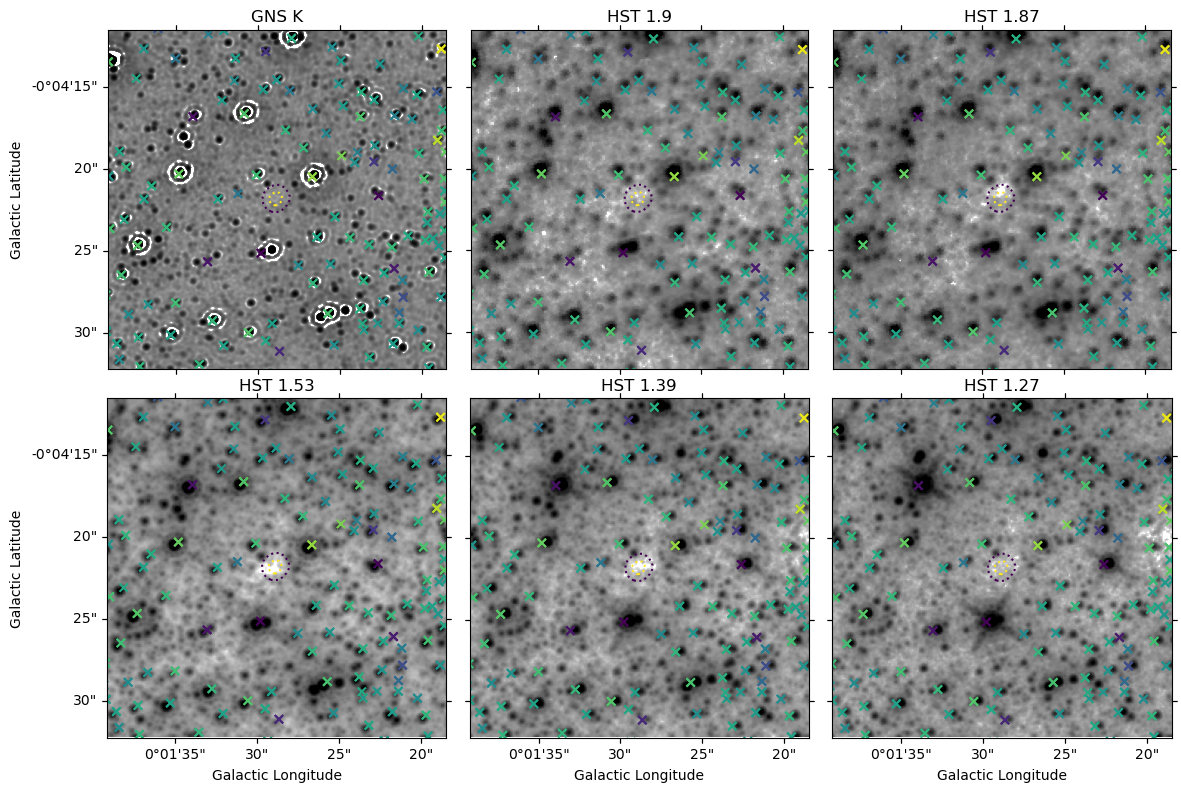

In [166]:
fig = pl.figure(figsize=(12,8))
for ii, (title, fh) in enumerate([('GNS K', fhgns),
                                  ('HST 1.9', fh190),
                                  ('HST 1.87', fh187),
                                  ('HST 1.53', fh153[1]),
                                  ('HST 1.39', fh139[1]),
                                  ('HST 1.27', fh127[1])]):

    print(ii)
    nirim, nirwcs = galactic_cutout(fh, region)
    
    ax = pl.subplot(2,3,ii+1,projection=nirwcs)
    norm = simple_norm(nirim.data, **stretch_kwargs[title])
    im = ax.imshow(nirim.data, cmap='gray_r', norm=norm)
    lims = ax.axis()
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               linestyles=':',
               levels=[0.0008,  0.0015, ]);

    crds = SkyCoord(hsc_stacked['F153M_RAJ2000'], hsc_stacked['F153M_DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    ax.scatter_coord(crds, marker='x', c=hsc_stacked['F139M_magAper2'] - hsc_stacked['F153M_magAper2'])
    
    ax.set_xlabel("Galactic Longitude")
    ax.set_ylabel("Galactic Latitude")
    ax.set_title(title)
    ax.axis(lims)
    if ii % 3 != 0:
        ax.set_ylabel("")
        ax.coords['glat'].set_ticklabel_visible(False)
    if ii < 3:
        ax.set_xlabel("")
        ax.coords['glon'].set_ticklabel_visible(False)
pl.tight_layout()

fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTall_GNS_zoomout_withHSTcat_colors.pdf', bbox_inches='tight')

In [90]:
virac[:2]

<Table length=2>
  srcid    RA_ICRS    DE_ICRS    Ksmag   KsEll      pm          e_pm         pmRA        e_pmRA        pmDE        e_pmDE      Nep  flgrel   Zmag    Zell    Ymag    Yell    Jmag    Jell    Hmag    Hell  Zdetflg Ydetflg Jdetflg Hdetflg
             deg        deg       mag            mas / yr     mas / yr     mas / yr     mas / yr     mas / yr     mas / yr                   mag             mag             mag             mag                                          
  int32    float64    float64   float32 float32  float64      float64      float64      float64      float64      float64     int16 uint8  float64 float32 float64 float32 float32 float32 float64 float32  uint8   uint8   uint8   uint8 
--------- ---------- ---------- ------- ------- ---------- ------------- ----------- ------------- ----------- -------------- ----- ------ ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- -------
215450598 266.487541 -28.955149  15.126     0.1      18.31         11.99        6.33         13.02      17.179         11.847     8      0      --      --  19.335  0.3426  19.006  0.1911      --      --       1       0       0       1
215496988 266.488697 -28.956139  14.516     0.6      17.51         30.43       14.07         29.35      10.426         32.295    51      0      --      --      --      --      --      --      --      --       1       1       1       1

## Spitzer

In [91]:
spitz = {
    '3.6um': '/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SPITZER_stolovy_I1_13368832_0000_6_E8709676_maic.fits',
    '4.5um': '/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SPITZER_stolovy_I2_13368832_0000_6_E8709929_maic.fits',
    '5.8um': '/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SPITZER_stolovy_I3_13368832_0000_6_E8709933_maic.fits',
    '8.0um': '/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SPITZER_stolovy_I4_13368832_0000_6_E8709940_maic.fits',
}
spitz = {key: fits.open(val) for key,val in spitz.items()}

0
1
2
3
4
5


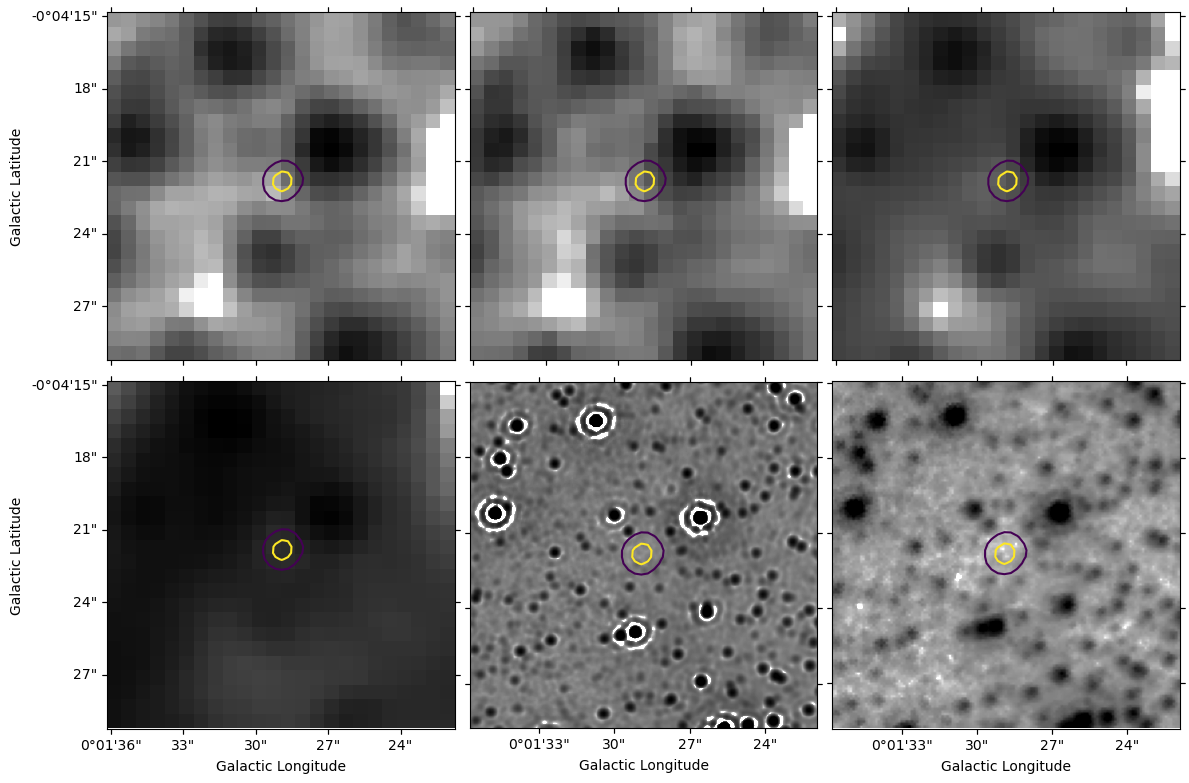

In [114]:
fhs = spitz.copy()
fhs['GNS K'] = fhgns
fhs['HST 1.9'] = fh190

fig = pl.figure(figsize=(12,8))
for ii, (title, fh) in enumerate(fhs.items()):

    print(ii)
    nirim, nirwcs = galactic_cutout(fh, mediumregion)
    
    ax = pl.subplot(2,3,ii+1, projection=nirwcs)
    #ax = pl.subplot(projection=contwcs_co)
    norm = simple_norm(nirim.data, **stretch_kwargs[title])
    im = ax.imshow(nirim.data, cmap='gray_r', norm=norm)
    lims = ax.axis()
    ax.contour(contim.data, transform=ax.get_transform(contwcs),
               levels=[0.0008,  0.0015, ]);

    # crds = SkyCoord(hsc['RAJ2000'], hsc['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    # crds = SkyCoord(gns['RAJ2000'], gns['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    # ax.scatter_coord(crds, marker='x', color='r')
    # crds = SkyCoord(virac['RA_ICRS'], virac['DE_ICRS'], frame='icrs', unit=(u.deg, u.deg))
    # ax.scatter_coord(crds, marker='x', color='b')
    # crds = SkyCoord(hst_dong['RAJ2000'], hst_dong['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    # ax.scatter_coord(crds, marker='x', color='g')
    # crds = SkyCoord(pmq['RAJ2000'], pmq['DEJ2000'], frame='fk5', unit=(u.deg, u.deg))
    # ax.scatter_coord(crds, marker='x', color='c')
    ax.set_xlabel("Galactic Longitude")
    #ax.grid()
    ax.set_ylabel("Galactic Latitude")
    #ax.set_title("HST Pa$\\alpha$")
    ax.axis(lims)
    if ii % 3 != 0:
        ax.set_ylabel("")
        ax.coords['glat'].set_ticklabel_visible(False)
    if ii < 3:
        ax.set_xlabel("")
        ax.coords['glon'].set_ticklabel_visible(False)
pl.tight_layout()